# **Setup**

1. Dependencies Installieren

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

2. Package importieren

In [2]:
#Packung für das Sammeln durch den Webcam
import os, time, uuid, cv2
from pathlib import Path

In [3]:
#Packung für Bilderverarbeitung
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
#Packung für die Ablumentation und die Bildung der Data-Pipeline
import albumentations as alb

In [5]:
#Packung für das Modelbau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

# Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting the right PATH

In [8]:
%pwd

'c:\\Users\\ttt\\Documents\\GitHub\\BilderkennungAI'

In [7]:
%cd "/content/drive/MyDrive/Programming/BilderkennungAI"

[WinError 3] Das System kann den angegebenen Pfad nicht finden: '/content/drive/MyDrive/Programming/BilderkennungAI'
c:\Users\ttt\Documents\GitHub\BilderkennungAI


# Bilder labeln



```
!labelme
```

Labelme öffnen, um Ausgangsdaten mit Labels zu versehen, dort wo Gesichter zu sehen sind (nach Akzepentanzkritierien PROJ-71)

Rechteck um das Gesicht, wenn kein Gesicht vorhanden Datei ignorieren

Labels als json in den labels Ordner übertragen

# **3. Die gesamte Datenmenge in kleineren Gruppen aufteilen**

Trennung der data/images Ordner in 3 kleineren Ordnern
```
#training_set
for x in range(int(len(l)*0.7)+1):
  file = l[x]
  EX_PATH = os.path.join("data","images",file)
  NEW_PATH = os.path.join("data","train","images",file)
  os.replace(EX_PATH,NEW_PATH)


#testing_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','images',file)
  NEW_PATH = os.path.join('data','test','images',file)
  os.replace(EX_PATH,NEW_PATH)

#validation_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','test','images',file)
  NEW_PATH = os.path.join('data','val','images',file)
  os.replace(EX_PATH,NEW_PATH)
```



Die passende Label für jedes Bildes in der richtige Ordner anordnen


```
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)
```



Image in eine tf data pipeline laden (Beispiel)

In [9]:
images = tf.data.Dataset.list_files(os.path.join('data/train/images/*.jpg'))

In [10]:
images.as_numpy_iterator().next()

b'data\\train\\images\\image70.jpg'

In [11]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(120,120))
    img = img/255
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[0.28791532, 0.35458198, 0.4718886 ],
        [0.13662173, 0.19344363, 0.29509804],
        [0.07807054, 0.10552152, 0.17908497],
        ...,
        [0.07826789, 0.09395417, 0.09787574],
        [0.06911765, 0.08480392, 0.08872549],
        [0.06666667, 0.08235294, 0.08627451]],

       [[0.3304126 , 0.39070672, 0.47600082],
        [0.24509804, 0.2990196 , 0.3704657 ],
        [0.10000001, 0.13104577, 0.18218955],
        ...,
        [0.07591908, 0.09160537, 0.09552693],
        [0.06758578, 0.08327206, 0.08719363],
        [0.06666667, 0.08235294, 0.08627451]],

       [[0.15264843, 0.20755039, 0.258204  ],
        [0.13941993, 0.18941993, 0.23500817],
        [0.08283632, 0.11780365, 0.14541802],
        ...,
        [0.0746732 , 0.09035947, 0.09428104],
        [0.07303922, 0.08872549, 0.09264706],
        [0.06356225, 0.07924853, 0.08317009]],

       ...,

       [[0.03529412, 0.05098039, 0.04705882],
        [0.05196078, 0.05245098, 0.04313726],
        [0.08627451, 0

In [14]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

Image visualisieren 

In [15]:
images_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = images_generator.next()

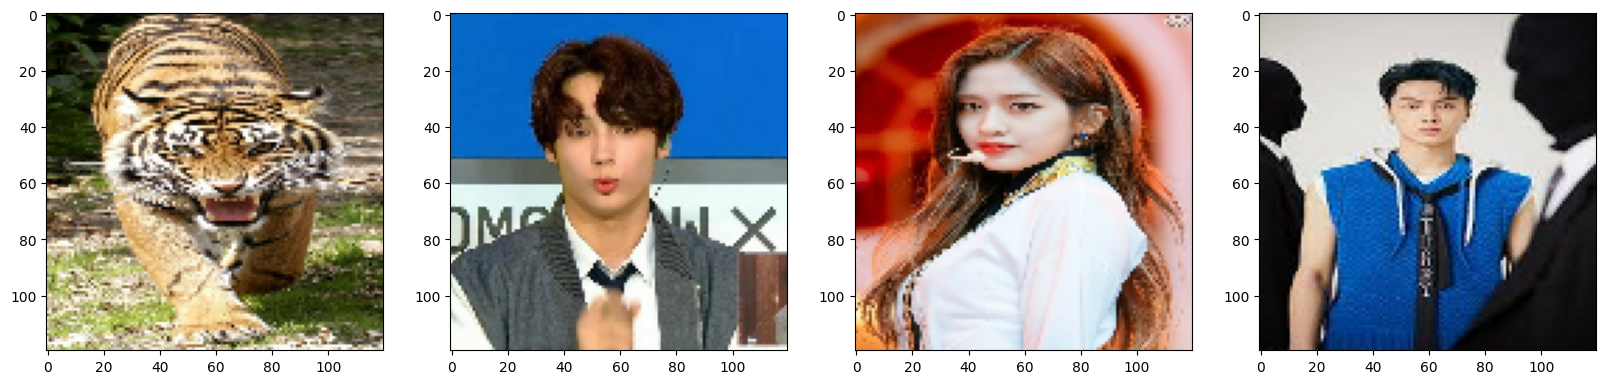

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# **4. Albumentation Setting für die Augmentatition den Bildern aufstellen**

In [18]:
augmentor = alb.Compose([alb.RandomCrop(width=500,height=500),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                        bbox_params= alb.BboxParams(format="albumentations",label_fields=["class_labels"]))
#

Laden eines Beispielbilds

In [93]:
image_path = "image22"

In [94]:
img = cv2.imread(os.path.join('data','train','images',image_path+".jpg"))

In [95]:
size= img.shape
print(size)

(650, 650, 3)


Koordinaten Extrahieren und Maßstab ändern

In [96]:
def arrange_coords(a):
    array= [0,0,0,0]
    if(a[0][0] < a[1][0]):
        array[0] = a[0][0]
        array[2] = a[1][0]
    else:
        array[0] = a[1][0]
        array[2] = a[0][0]
    
    if(a[0][1] < a[1][1]):
        array[1] = a[0][1]
        array[3] = a[1][1]
    else:
        array[1] = a[1][1]
        array[3] = a[0][1]
    return array



In [97]:
coords = [0,0,0.0001,0.0001]
label_path = os.path.join('data', 'train', 'labels', f'{image_path}.json')
if os.path.exists(label_path):
  with open(label_path, 'r') as f:
   label = json.load(f)
   coords = arrange_coords(label['shapes'][0]['points'])
   coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))
coords  

  #coords[0] = label['shapes'][0]['points'][0][0]
  #coords[1] = label['shapes'][0]['points'][0][1]
  #coords[2] = label['shapes'][0]['points'][1][0]
  #coords[3] = label['shapes'][0]['points'][1][1]


[0.19628647214854114,
 0.08015915119363395,
 0.6238726790450928,
 0.5544297082228117]

In [98]:
c = [0,0,0,0]
c[0] = label['shapes'][0]['points'][0][0]
c[1] = label['shapes'][0]['points'][0][1]
c[2] = label['shapes'][0]['points'][1][0]
c[3] = label['shapes'][0]['points'][1][1]
c = list(np.divide(c,[size[1],size[0],size[1],size[0]]))
c

[0.6238726790450928,
 0.5544297082228117,
 0.19628647214854114,
 0.08015915119363395]

In [70]:
label['shapes'][0]['points']

[[190.34482758620692, 113.48275862068967],
 [397.9310344827586, 314.17241379310343]]

Augmentation implimentieren

In [99]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [100]:
augmented['bboxes']


[(0.30896551724137933, 0.0, 0.8648275862068965, 0.5347586206896552)]

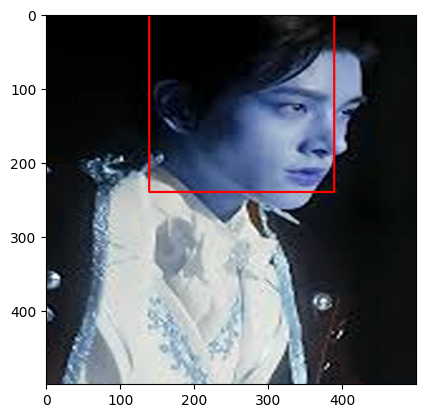

In [101]:
if(augmented['bboxes']):
 cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

Aug-data Ordner herstellen

In [102]:
for path in ['train','test','val']:
  for folder in ['images','labels']:
   PATH = os.path.join('aug_data',path,folder)
   os.makedirs(PATH)

# **5. Augmentation Pipeline durchführen**

In [103]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        size = img.shape

        coords = [0,0,0.000001,0.000001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            coords = arrange_coords(label['shapes'][0]['points'])
            coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)
            print(label_path)

## **6.Die Augmented Bildern zu eine Tensorflow Dataset laden**

In [104]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle= False)
train_images = train_images.map(load_image)

In [105]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle= False)
test_images = test_images.map(load_image)

In [106]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle= False)
val_images = val_images.map(load_image)

In [ ]:
train_images.as_numpy_iterator().next()

Labels vorbereiten

In [108]:
def load_labels(label_path):
  with open(label_path.numpy(),'r', encoding = "utf-8") as f:
    label = json.load(f)
  
  return [label['class']],label['bbox']

In [109]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle= False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [110]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle= False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [111]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle= False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [112]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.447 , 0.    , 0.833 , 0.4756], dtype=float16))

# **7. Combine Image and Label Sampels**

7.1 Check Partition Lengths

In [113]:
len(train_images), len(train_labels), len(test_images), len(test_labels),len(val_images), len(val_labels)

(2880, 2880, 960, 960, 960, 960)

7.2 Create Final Dataset (Image/Label)

In [114]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [115]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [116]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()

7.3 View Images and Annotations

In [118]:
data_samples = train.as_numpy_iterator()

In [119]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


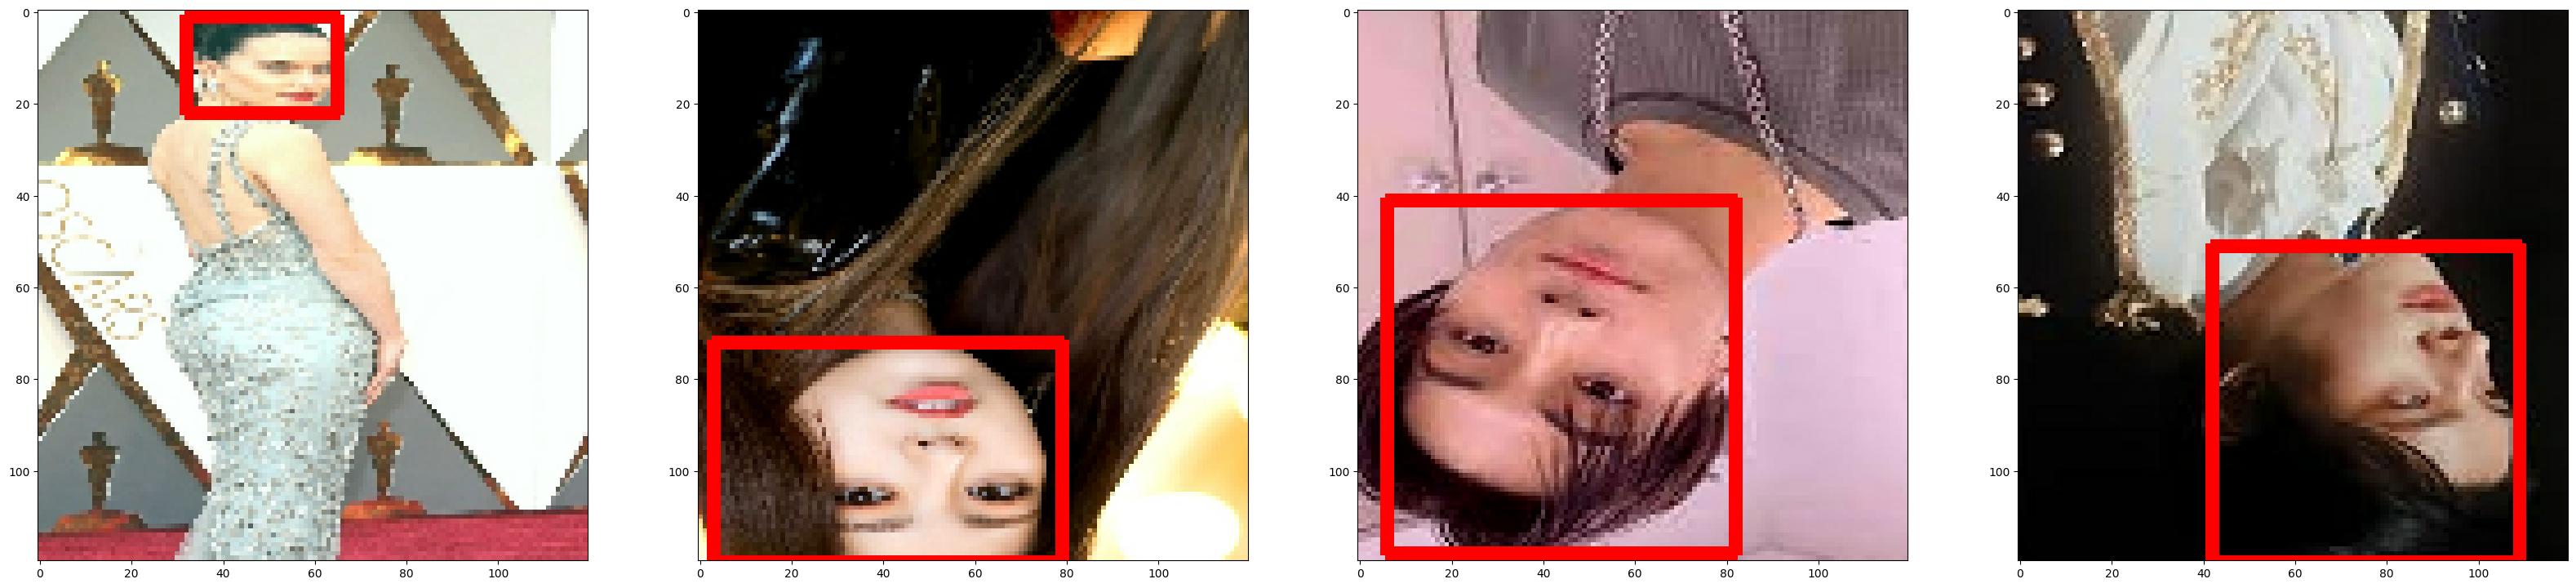

In [120]:
fig, ax = plt.subplots(ncols=4, figsize=(40, 40))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# **8. Aufbauen des Deep Learning-Modells**

### 8.1 Base Network sowie Layers importieren und VGG16 installieren

In [121]:
vgg = VGG16(include_top=False)

In [122]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.2 Eine Instanz des Neural Networks bauen

In [123]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.3 Testen des Neural Networks

In [124]:
facetracker = build_model()

In [125]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_5[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [126]:
X, y = train.as_numpy_iterator().next()

In [127]:
y[1][:,:2]

array([[0.1769, 0.    ],
       [0.    , 0.    ],
       [0.    , 0.    ],
       [0.    , 0.    ],
       [0.1631, 0.    ],
       [0.1537, 0.    ],
       [0.219 , 0.    ],
       [0.    , 0.    ]], dtype=float16)

In [128]:
X.shape

(8, 120, 120, 3)

In [129]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 7s 7s/step


In [130]:
classes, coords

(array([[0.63134944],
        [0.46781105],
        [0.49754992],
        [0.49833497],
        [0.53181875],
        [0.60616785],
        [0.49849346],
        [0.49309263]], dtype=float32),
 array([[0.4023415 , 0.57717294, 0.5740692 , 0.5103024 ],
        [0.42797884, 0.5365708 , 0.4537264 , 0.49875084],
        [0.43337452, 0.5812273 , 0.4875643 , 0.5116538 ],
        [0.4224505 , 0.56578755, 0.51474535, 0.5317562 ],
        [0.46699047, 0.5749049 , 0.4754988 , 0.559558  ],
        [0.40385786, 0.67257786, 0.6203185 , 0.59795433],
        [0.44387123, 0.54363966, 0.5173194 , 0.5744507 ],
        [0.42487112, 0.5872742 , 0.50575006, 0.5369077 ]], dtype=float32))

In [131]:
coords[:,:2]

array([[0.4023415 , 0.57717294],
       [0.42797884, 0.5365708 ],
       [0.43337452, 0.5812273 ],
       [0.4224505 , 0.56578755],
       [0.46699047, 0.5749049 ],
       [0.40385786, 0.67257786],
       [0.44387123, 0.54363966],
       [0.42487112, 0.5872742 ]], dtype=float32)

# **9.Define Losses and Optimizer**

## 9.1 Define Optimizer

In [132]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/ batches_per_epoch

In [133]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [134]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [135]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [136]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.143449>

In [137]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6255008>

In [138]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.143449>

# **10.Train Neural Network**

## 10.1 Create Custom Model Class

In [139]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [143]:
model = FaceTracker(facetracker)

In [144]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [145]:
logdir='logs'

In [146]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [147]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
360/360 [==============================] - 100s 243ms/step - total_loss: 0.1022 - class_loss: 0.0200 - regress_loss: 0.0922 - val_total_loss: 0.0551 - val_class_loss: 2.9358e-04 - val_regress_loss: 0.0549
Epoch 2/15
360/360 [==============================] - 114s 297ms/step - total_loss: 0.0236 - class_loss: 0.0048 - regress_loss: 0.0212 - val_total_loss: 0.1395 - val_class_loss: 0.0011 - val_regress_loss: 0.1389
Epoch 3/15
360/360 [==============================] - 71s 181ms/step - total_loss: 0.0365 - class_loss: 0.0114 - regress_loss: 0.0308 - val_total_loss: 0.3012 - val_class_loss: 0.0015 - val_regress_loss: 0.3004
Epoch 4/15
360/360 [==============================] - 72s 182ms/step - total_loss: 0.0112 - class_loss: 2.8458e-04 - regress_loss: 0.0111 - val_total_loss: 0.0593 - val_class_loss: 5.1256e-04 - val_regress_loss: 0.0590
Epoch 5/15
360/360 [==============================] - 80s 205ms/step - total_loss: 0.0037 - class_loss: 5.9538e-05 - regress_loss: 0.0037 - va

## 10.3 Plot Performance

In [ ]:
hist.history

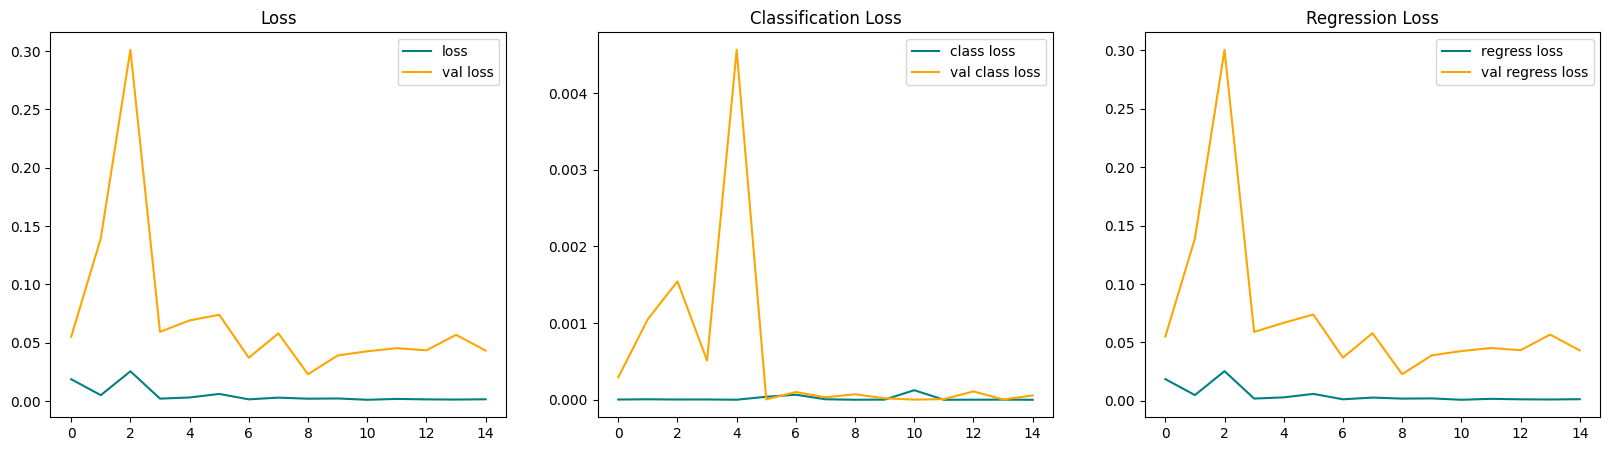

In [148]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# **11. Make Prediction**

## 11.1 Making Prediction on test set for valuation purpose

In [149]:
test_data = test.as_numpy_iterator()

In [150]:
test_sample = test_data.next()
test_sample

(array([[[[0.5561819 , 0.5310185 , 0.5516067 ],
          [0.55588233, 0.5323529 , 0.5480392 ],
          [0.5613834 , 0.54163945, 0.5573257 ],
          ...,
          [0.6107841 , 0.57483655, 0.5562089 ],
          [0.62679726, 0.5826797 , 0.5767971 ],
          [0.6330065 , 0.5977124 , 0.57810456]],
 
         [[0.5603758 , 0.54076797, 0.55645424],
          [0.56764704, 0.5480392 , 0.5637255 ],
          [0.5686275 , 0.54901963, 0.5647059 ],
          ...,
          [0.62581694, 0.5826796 , 0.56699336],
          [0.6421567 , 0.59901947, 0.5867644 ],
          [0.65294117, 0.6137255 , 0.60588235]],
 
         [[0.5767974 , 0.5571896 , 0.58006537],
          [0.5833333 , 0.5637255 , 0.5812091 ],
          [0.5791394 , 0.5604303 , 0.57581705],
          ...,
          [0.6359748 , 0.6006263 , 0.5810456 ],
          [0.6519607 , 0.61666656, 0.5970587 ],
          [0.6627451 , 0.627451  , 0.60784316]],
 
         ...,
 
         [[0.76525044, 0.66002154, 0.62995607],
          [0.66307

In [151]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 300ms/step


In [152]:
yhat

[array([[2.5562180e-04],
        [9.9997723e-01],
        [2.2596707e-09],
        [9.9999976e-01],
        [2.3664390e-13],
        [9.9998915e-01],
        [9.9999642e-01],
        [9.9999905e-01]], dtype=float32),
 array([[6.4466186e-03, 7.7182925e-03, 8.7256106e-03, 8.0534536e-03],
        [1.1658259e-01, 3.7380422e-03, 6.7412096e-01, 2.6009583e-01],
        [4.7584413e-06, 6.6756525e-06, 1.2185538e-05, 1.1551289e-05],
        [3.5722679e-01, 3.1426582e-03, 9.6087998e-01, 6.4901966e-01],
        [1.6166066e-08, 2.9024891e-08, 5.1867652e-08, 8.1243478e-08],
        [2.2591662e-01, 6.0942942e-01, 7.7164412e-01, 9.9102563e-01],
        [3.3045441e-01, 3.9232293e-01, 9.1719764e-01, 9.8787028e-01],
        [3.5767570e-01, 1.3885693e-02, 7.9707098e-01, 5.1593220e-01]],
       dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


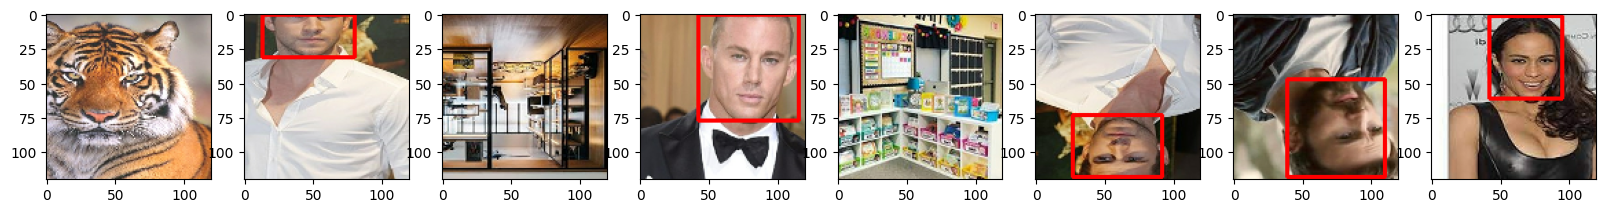

In [153]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx in range(8): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the model

In [154]:
#Model Speicherung
from tensorflow.keras.models import load_model

In [155]:
facetracker.save('facetracker.h5')

In [156]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [184]:
cap = cv2.VideoCapture('http://192.168.0.132:8080/video')
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 123ms/step


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1267: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [179]:
rtp_test = cv2.imread(os.path.join("producttest/messi.jpg"))
rtp_test= cv2.cvtColor(rtp_test, cv2.COLOR_BGR2RGB)

In [180]:
resized = tf.image.resize(rtp_test, (120,120))
size = rtp_test.shape
yhat = facetracker.predict(np.expand_dims(resized/255,0))
status = yhat[0]
sample_coords = yhat[1][0]


1/1 [==============================] - 0s 38ms/step


Es gibt ein Gesicht


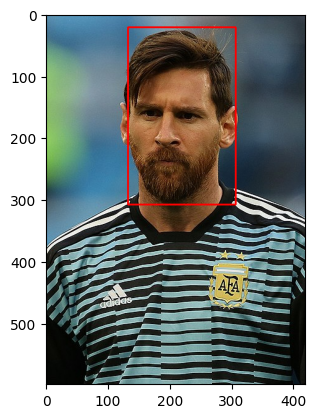

In [181]:
if (status > 0.5):
    print("Es gibt ein Gesicht")
    cv2.rectangle(rtp_test,
              tuple(np.multiply(sample_coords[:2], [size[1],size[0]]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [size[1],size[0]]).astype(int)),
              (255,0,0),2)
else:
    print("Es gibt kein Gesicht")
plt.imshow(rtp_test)